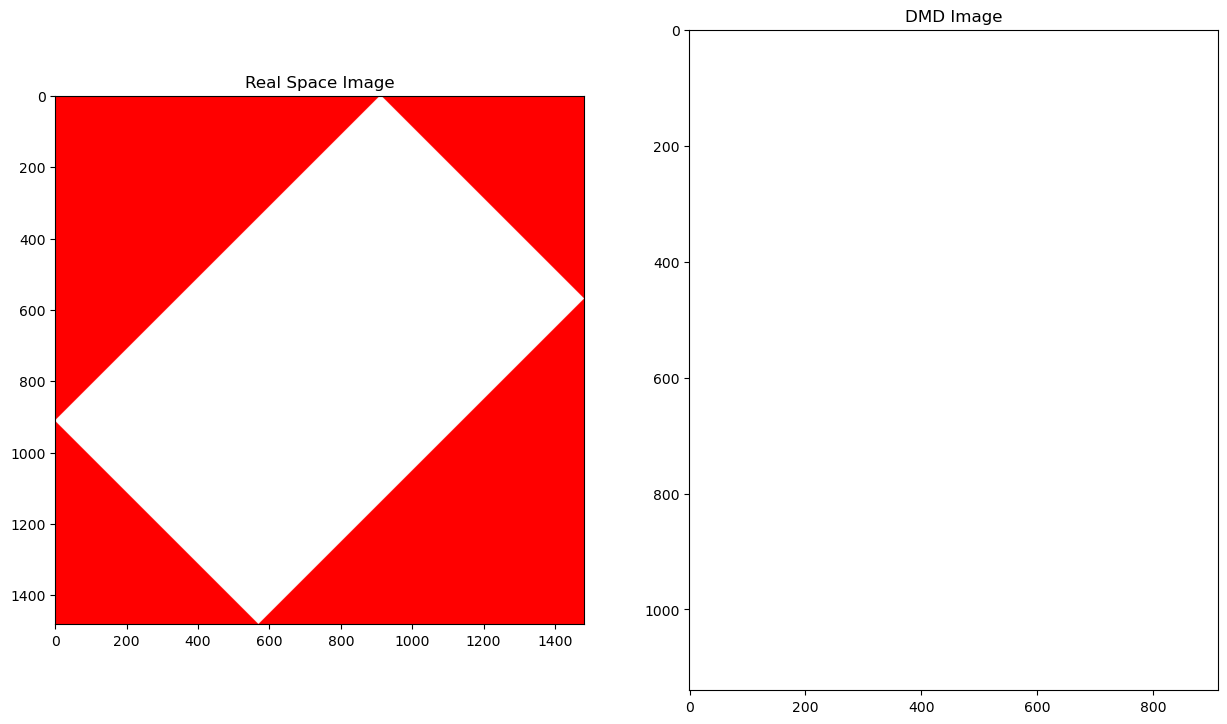

In [1]:
from utils import BinaryFrame, GrayscalePainter

dmd = BinaryFrame()
painter = GrayscalePainter()
dmd.setRealArray(color=1)
dmd.displayPattern()